In [1]:
# import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA

In [2]:
# import data
df = pd.read_csv('winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# compute binary outcome (high quality >=7)
df['high quality'] = np.where(df['quality']>6, 1, 0)
df.head(10)

# drop the quality column
df.drop(['quality'], axis=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,0


In [4]:
# look for missing data --> there is none
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
high quality            0
dtype: int64

In [5]:
# split into training and test (70/30)
X = df.copy().drop('high quality', axis=1)
y = df['high quality']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42, stratify = y )

In [ ]:
# # 'outlier' detection: compute Mahalanobis distances
# # https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3
# # incognito mode ;)

# def mahalanobis(my_X, my_y):
#     data = my_X.copy()
#     y_data = my_y.copy()
#     # compute distances of each observation from centerpoint
#     distances = []
#     for i, val in enumerate(data.to_numpy()):
#         p1 = val
#         p2 = np.mean(data, axis = 0)
#         distance = (p1-p2).T.dot(np.linalg.matrix_power(np.cov(data, rowvar=False), -1)).dot(p1-p2)
#         distances.append(distance)
    
#     # convert list to numpy array
#     distances = np.array(distances)

#     # set cutoff threshold from Chi-square distribution for outlier detection
#     cutoff = chi2.ppf(0.99, data.shape[1])

#     # get indices 'outliers' that exceed cutoff
#     outliers = np.where(distances > cutoff)
#     outliers = list(outliers[0])
    
#     # see number of 'outliers' detected
#     print ('There are', len(outliers), 'values that exceed cutoff for outlier detection.')
    
#     # see which observations are outliers
#     print(outliers)

#     # return df without outliers
#     X_df = data.drop(data.index[outliers])
#     y_df = y_data.drop(y_data.index[outliers])
#     return(X_df, y_df)


In [ ]:
# # use function to remove values that exceed cutoff ('outliers')
# # note, this procedure is meant for normally distributed data
# # in the literature there are nonparametric methods described.
# # e.g. 'Mahalanobis beyond normal distributions' by Joakim Ekstrom
# train = mahalanobis(X_train, y_train)

In [6]:
# Power Transformer Scaler to deal with data that is not normally distributed.
# This is essentially a Box-Cox procedure
scaler = PowerTransformer(method='yeo-johnson')
X_trSc = scaler.fit_transform(X_train)
X_teSc = scaler.fit_transform(X_test)


In [7]:
# perform Support Vector Classificiation
model = SVC()
model.fit(X_trSc, y_train)
y_pred = model.predict(X_teSc)
balanced_accuracy_score(y_test, y_pred)


0.9846153846153847

Text(0.5, 1.0, 'Support Vector Classification Performance')

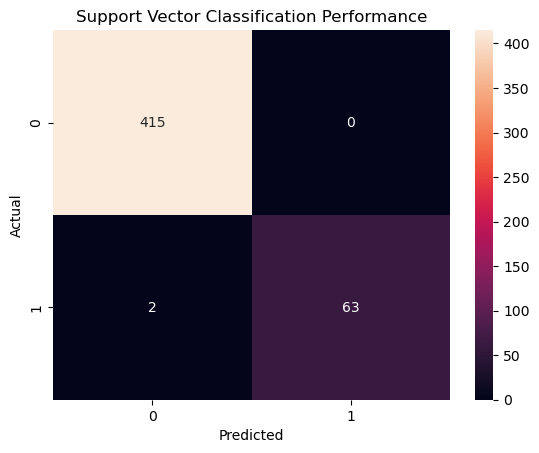

In [8]:
ax = plt.subplot( )
sns.heatmap(confusion_matrix(y_test, y_pred),
annot = True,
fmt = 'g',
ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Support Vector Classification Performance')
